# Upper Confidence Bound Bandit

In [1]:
# Import modules.
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import import_ipynb
from abstract_bandit import Bandit

importing Jupyter notebook from abstract_bandit.ipynb


In [2]:
class UCBBandit(Bandit):

    def __init__(self, means, sigmas, init_est, arms=10, iters=10000, c=0.0, alpha=None, deterministic=False, stationary=True):
        """Initializes the Upper Confidence Bound bandit."""
        super().__init__(means, sigmas, deterministic=deterministic, stationary=stationary)
        self.c = c
        self.alpha = alpha
        self.uncerts = np.zeros(arms)
        self.est_means = np.full(arms, init_est)
        self.Qs = np.zeros((iters + 1, arms))
        self.Qs[0, :] = self.est_means

    def choose_action(self):
        """Implements the Upper Confidence Bound policy, based on time passage."""
        return np.argmax(self.est_means + self.uncerts)

    def update_model(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Update choice count.
        self.Ns[arm] += 1
        # Update step size.
        if self.alpha == None:
            step_size = 1. / self.Ns[arm]
        else:
            step_size = self.alpha
        # Update reward estimate.
        self.est_means[arm] = self.est_means[arm] + step_size * (reward - self.est_means[arm])
        # Update uncertainties.
        for i in range(self.arms):
            if self.Ns[i] == 0.0:
                self.uncerts[i] = np.inf
            else:
                self.uncerts[i] = self.c * np.sqrt(np.log(iteration + 1) / self.Ns[i])
        # Decrease exploration probability.
        if (self.stationary == True) and (self.c >= ((self.c / self.iters) * (iteration + 1))):
            self.c -= (self.c / self.iters) * (iteration + 1)
        # Eventually increase optimal actions counter.
        if arm == np.argmax(self.means):
            self.opt_actions += 1.0
        # Update real action values.
        if self.stationary == False:
            for i in range(self.arms):
                self.means[i] += np.random.normal()

    def update_sim_data(self, arm , reward, iteration):
        """Updates simulation data after an episode"""
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + (1. / (iteration + 1)) * (reward - self.avg_rewards[iteration]) 
        self.Qs[iteration + 1, :] = self.Qs[iteration, :]
        self.Qs[iteration + 1, arm] = self.est_means[arm]
        self.qs[iteration + 1, :] = self.means

    def get_est_means(self):
        """Returns estimated action values."""
        return np.copy(self.Qs)

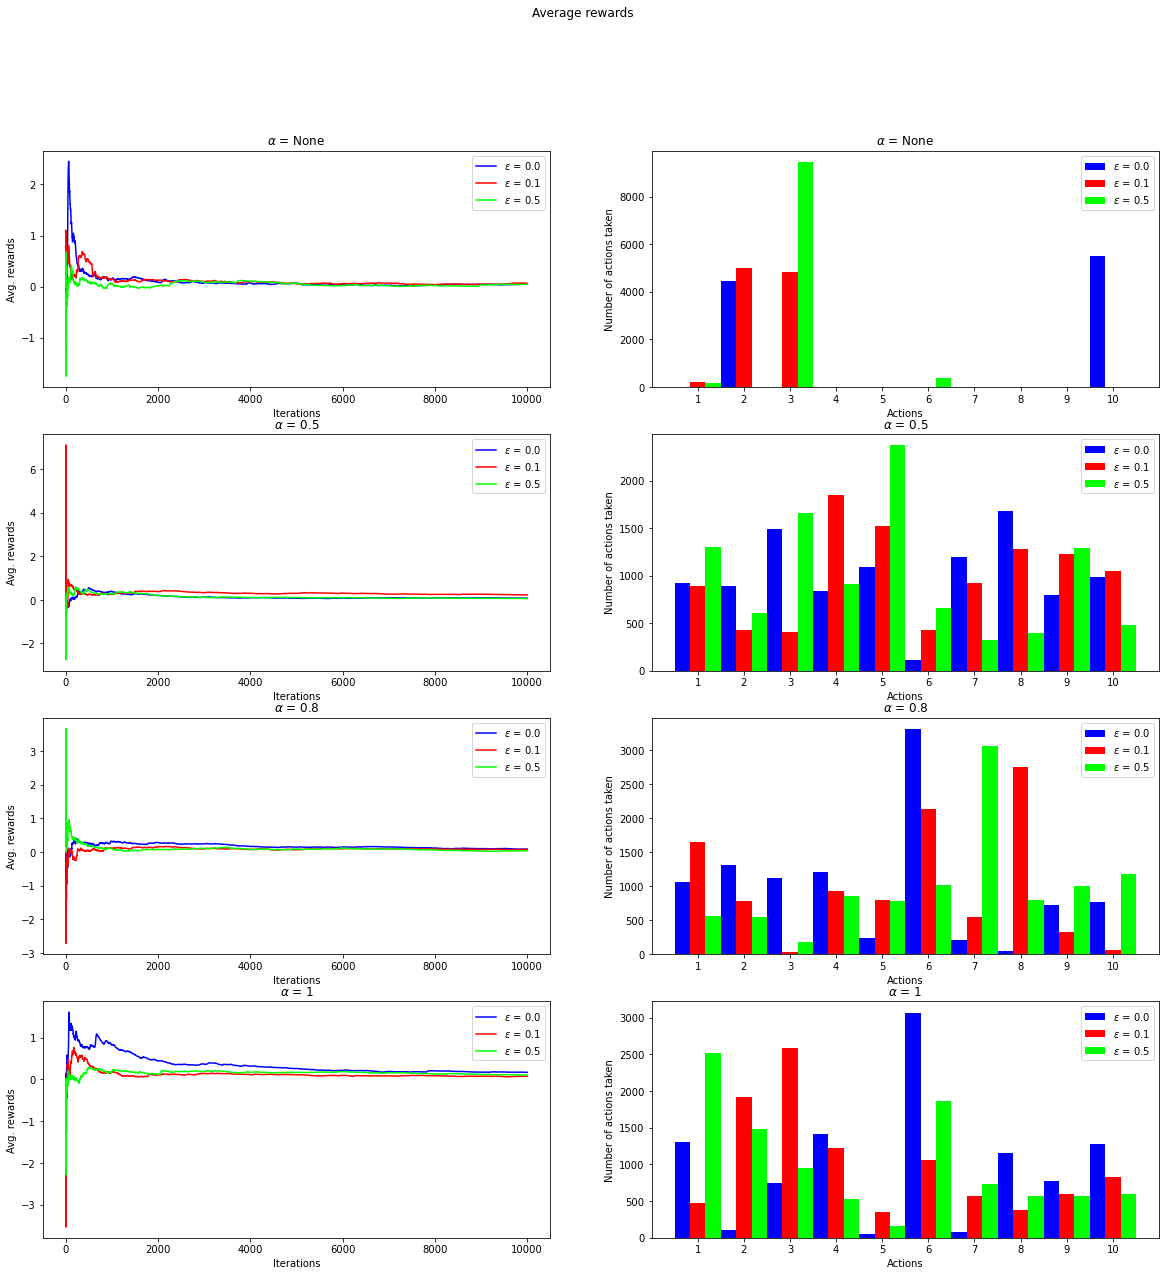

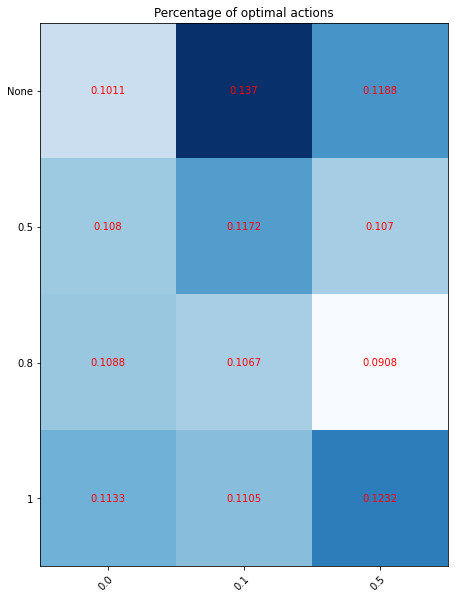

In [3]:
# Simulation parameters (some MUST be floats!).
iters = 10000
opt_init = 50.0
arms = 10
#means = list(range(1, arms+1))
means = np.full(arms, 0)
sigmas = np.full(arms, 1)
alphas = [None, 0.5, 0.8, 1]
cs = [0.0, 0.1, 0.5]
det = False
stat = False

# Simulation data array.
rews = np.zeros((len(alphas), len(cs), iters + 1))
actions = np.zeros((len(alphas), len(cs), arms))
optimals = np.zeros((len(alphas), len(cs)))

# Bandits execution.
for i in range(len(alphas)):
    for j in range(len(cs)):
        bandit = UCBBandit(means, sigmas, opt_init, alpha=alphas[i], c=cs[j], deterministic=det, stationary=stat)
        bandit.run()
        rews[i, j, :] = bandit.get_avg_rewards()
        actions[i, j, :] = bandit.get_actions()
        optimals[i, j] = bandit.get_opt_actions()

fig, ax = plt.subplots(len(alphas), 2, figsize=(20, 20))
fig.suptitle('Average rewards')
colors = cm.brg(np.linspace(0, 1, len(cs)))
for i in range(len(alphas)):
    # Average rewards subplots.
    for j in range(len(cs)):
        ax[i, 0].plot(rews[i, j, :], color=colors[j], label=r'$\epsilon$ = ' + str(cs[j]))
    ax[i, 0].legend(loc='upper right')
    ax[i, 0].set(xlabel='Iterations', ylabel='Avg. rewards')
    ax[i, 0].set_title(r'$\alpha$ = ' + str(alphas[i]))
    # Actions taken subplots.
    x = np.arange(arms)
    width = 1
    pos = list(range(1 - len(cs), len(cs), 2))
    for j in range(len(cs)):
        ax[i, 1].bar(x * width + pos[j] / (2.0 * len(cs)), actions[i, j, :], width / len(cs), color=colors[j], label=r'$\epsilon$ = ' + str(cs[j]))
    ax[i, 1].legend(loc='upper right')
    ax[i, 1].set_xticks(x)
    ax[i, 1].set_xticklabels(np.arange(1, arms+1))
    ax[i, 1].set(xlabel='Actions', ylabel='Number of actions taken')
    ax[i, 1].set_title(r'$\alpha$ = ' + str(alphas[i]))
    
# Frequency plots.
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(optimals, cmap='Blues')
ax.set_xticks(np.arange(len(cs)))
ax.set_yticks(np.arange(len(alphas)))
ax.set_xticklabels(map(str, cs))
ax.set_yticklabels(map(str, alphas))
ax.set_title("Percentage of optimal actions")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(alphas)):
    for j in range(len(cs)):
        text = ax.text(j, i, optimals[i, j], ha="center", va="center", color='r')